# Fun with Gamma Ray Bursts.

There are plenty of astrophysical problems where clustering can be useful. As an example, this is a plot of the distributions of Gamma Ray Bursts. Can you see two classes there? These are the so-called short GRBs and long GRBs. The long ones come from supernovae, the short ones come from neutron star mergers.

![](https://ars.els-cdn.com/content/image/1-s2.0-S2214404815000129-gr001_lrg.jpg)

Figure from "The Second Swift BAT Gamma-Ray Burst Catalog", [Sakamoto et al 2011](https://arxiv.org/abs/1104.4689).

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

In [2]:
import requests
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [4]:
# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

#Pack into python dictionary and convert selected fields to float
grb=dict(zip(names,data))

for label in ['T90','T90_error','fluence','fluence_error','redshift']:
    grb[label] = np.array(grb[label],dtype='float')


In [5]:
#T0=np.array(data[2],dtype=float)
ra=np.array(data[3],dtype=float)
decl=np.array(data[4],dtype=float)
pos_err=np.array(data[5],dtype=float)
T90=np.array(data[6],dtype=float)
T90_err=np.array(data[7],dtype=float)
#T90_start=np.array(data[8],dtype=float)
fluence=np.array(data[9],dtype=float)
fluence_err=np.array(data[10],dtype=float)
redshift=np.array(data[11],dtype=float)
T100=np.array(data[12],dtype=float)
GMB_located=np.array(data[13]) #,dtype=bool

Are there any structures underlying physical problems hidden in data? Histogram of T90

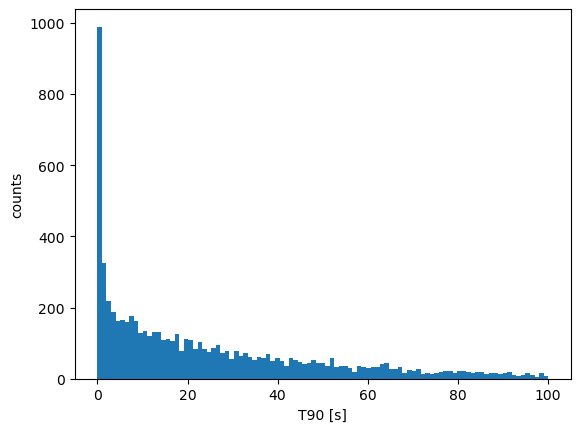

In [6]:
plt.hist(grb['T90'],bins= np.linspace(0,100,100))
plt.xlabel("T90 [s]") ; plt.ylabel("counts")
plt.show()

No information in linear scale. Let's try with log scale

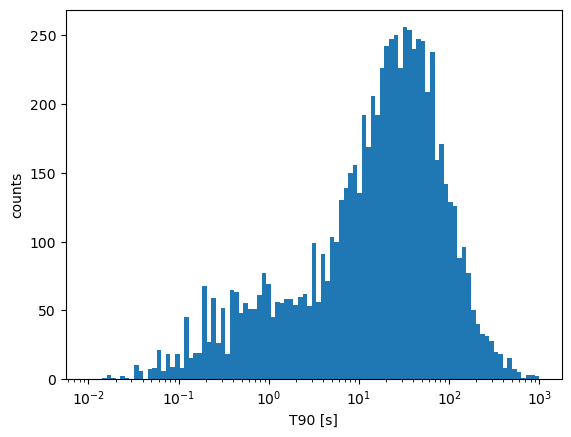

In [7]:
plt.hist(grb['T90'],bins= np.logspace(-2,3,100))
plt.semilogx() #plt.xscale("log")
plt.xlabel("T90 [s]") 
plt.ylabel("counts")
plt.show()

In log scale two distributions appear to be. But this can be due only to bin size. Let's do a fit with KDE kernel density estimation

In [6]:
# I want to fit the log of T90...
lT90 = np.log10(grb['T90'])
# Some cleaning...
lT90=lT90[~np.isnan(lT90)] 
# Reshape for scikit-learn
lT90 = lT90[:,np.newaxis]

/tmp/ipykernel_4875/1038571007.py:2: RuntimeWarning: invalid value encountered in log10
  lT90 = np.log10(grb['T90'])


In [9]:
# Fit a KDE with arbitrary bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(lT90) #fit the model to the data

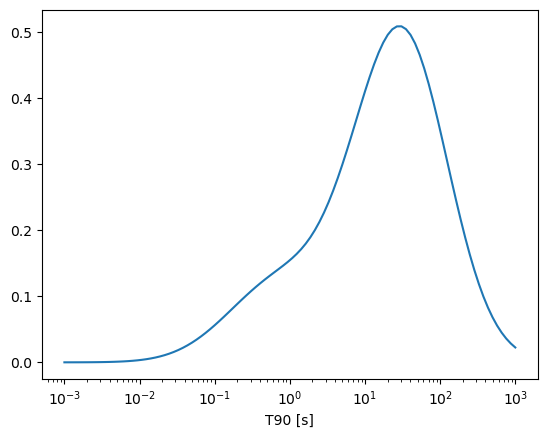

In [10]:
xgrid=np.logspace(-3,3,100)
# Rememember score_samples is the log-likelohood. Neep an exp in front
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.semilogx()
plt.xlabel("T90 [s]") 
plt.show()

In [11]:
# Now we should try to optimize the bandwidth with cross-validation
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.01,1.0, 40) # Test 40 bandwidths from 0.1 to 1.0

K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(lT90) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)


0.11153846153846153


In [13]:
# we could also tune the bandwidth with Freedman-Diaconis rule?
q_75 = np.quantile(lT90,0.75)
q_25 = np.quantile(lT90,0.25)
print(2*(q_75-q_25)/len(lT90)**(1/3))

0.09979833437042775


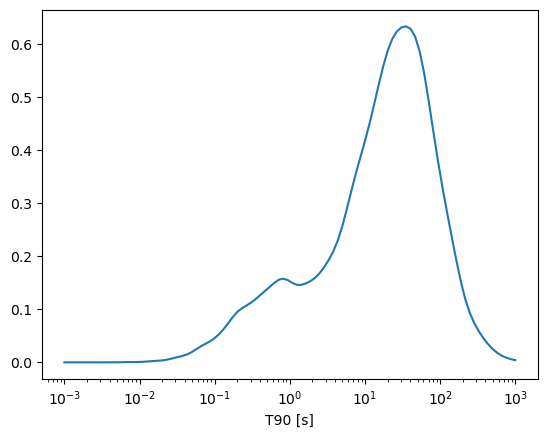

In [14]:
# Fit a KDE with optimized bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(lT90) #fit the model to the data
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.semilogx()
plt.xlabel("T90 [s]") 
plt.show()

### Un supervised clustering with KMeans 

In [15]:
clf = KMeans(n_clusters=2, n_init='auto') #Try 2 clusters to start with
clf.fit(lT90)

KMeans(n_clusters=2, n_init='auto')

In [16]:
centers = clf.cluster_centers_ #location of the clusters
centers = 10**np.squeeze(centers) #squeeze() function is used when we want to remove single-dimensional entries from the shape of an array
centers #in seconds

array([32.61994969,  0.8762506 ])

In [17]:
labels = clf.predict(lT90) #labels for each of the points. 0 for short bursts, 1 for long bursts 

In [18]:
if centers[0]>centers[1]:
    centers=centers[::-1] # Reverse array
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int') # Swap 0 <--> 1

In [19]:
centers, labels

(array([ 0.8762506 , 32.61994969]), array([1, 1, 1, ..., 0, 1, 0]))

In [20]:
print(np.squeeze(lT90).shape)
print(lT90.reshape(-1,).shape)
print(lT90.ravel().shape)

(7634,)
(7634,)
(7634,)


5.311999999999999 5.3500000000000005 5.330966141329355


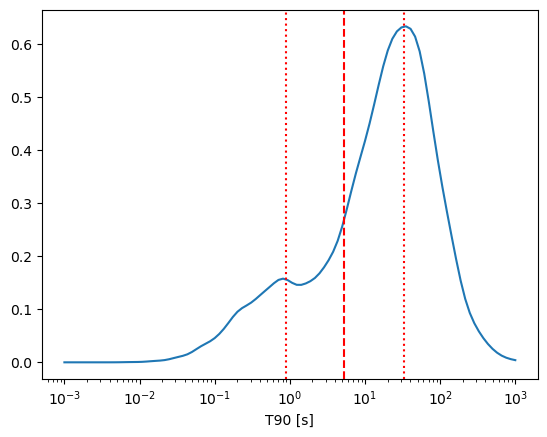

In [22]:
# Flatten the arrays (optional but clean)
group0 = lT90[labels == 0].ravel()
group1 = lT90[labels == 1].ravel()

# Compute edge
edge = np.mean([np.max(group0), np.min(group1)])

# Print values
print(10**np.max(group0), 10**np.min(group1), 10**edge)


plt.plot(xgrid,ygrid)
plt.semilogx()
for v in centers:
    plt.axvline(v, c='red',ls='dotted')
plt.axvline(10**edge,c='red',ls='dashed')
plt.xlabel("T90 [s]") 
plt.show()

In [23]:
print(lT90.shape)

(7634, 1)


### Gaussian mixtures and model selection criteria

In [34]:
gauss_mixture_models = []
for N in range(1, 2):
    model = GaussianMixture(n_components=N, max_iter=100, tol=1e-2, n_init=1, random_state=0)
    model.fit(lT90)  # (7613, 1) is fine
    gauss_mixture_models.append(model)
    

In [35]:
print(gauss_mixture_models[0])


GaussianMixture(random_state=0, tol=0.01)


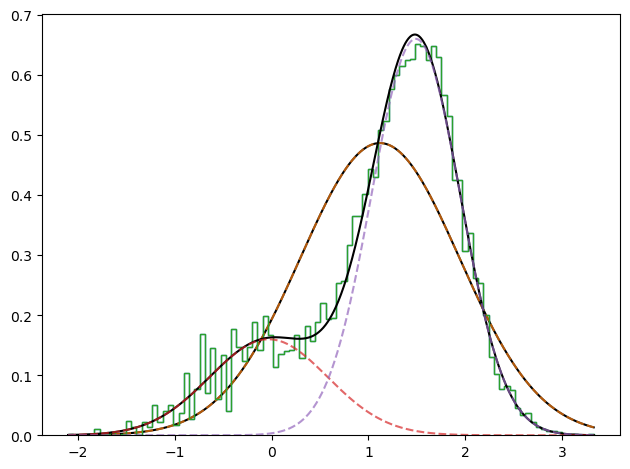

In [48]:
from sklearn.mixture import GaussianMixture


# Fit GMM(s)
gauss_mixture_models = []
for N in range(1, 3):  # just N=1 for now
    model = GaussianMixture(n_components=N, max_iter=100, tol=1e-2, n_init=1, random_state=0)
    model.fit(lT90)
    gauss_mixture_models.append(model)


# lT90 = log10(T90) and is shape (7613, 1)
# data = lT90.ravel(), a 1D version for plotting
# x = np.linspace(min(data), max(data), 1000)  
data = lT90.ravel()
data = data[~np.isnan(data)]
x = np.linspace(np.nanmin(data), np.nanmax(data), 1000)
x_reshaped = x.reshape(-1, 1)

for gmm in gauss_mixture_models:

    # Histogram
    plt.hist(data, bins=100, histtype='step', density=True)

    # Overall GMM PDF
    logprob = gmm.score_samples(x_reshaped)
    pdf = np.exp(logprob)
    plt.plot(x, pdf, c='black', label='GMM PDF')

    # Individual Gaussians
    for weight, mean, cov in zip(gmm.weights_, gmm.means_.ravel(), gmm.covariances_.ravel()):
        std = np.sqrt(cov)
        component_pdf = weight * (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) ** 2) / cov)
        plt.plot(x, component_pdf, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [46]:
AIC = [m.aic(lT90) for m in gauss_mixture_models]
for i in range(10):
    print(f"N={i+1}, AIC={AIC[i]:.2f}")
print('The AIC is minimized for N=', range(1,11)[np.argmin(AIC)])

N=1, AIC=18651.15
N=2, AIC=17039.54
N=3, AIC=17120.72
N=4, AIC=17195.05
N=5, AIC=17179.78
N=6, AIC=17183.52
N=7, AIC=17182.25
N=8, AIC=17153.35
N=9, AIC=17174.26
N=10, AIC=17165.95
The AIC is minimized for N= 2


# Fluence vs T90

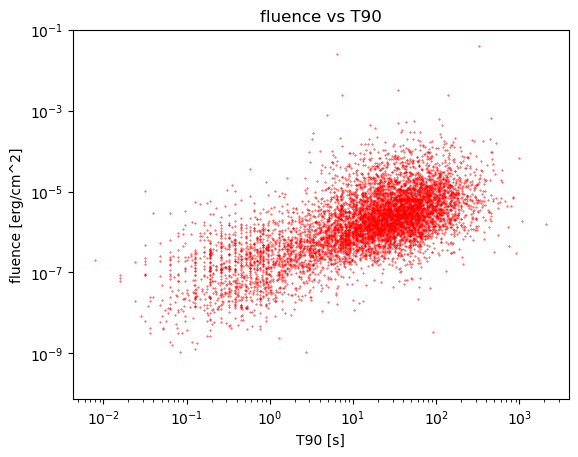

In [7]:
plt.title("fluence vs T90")
plt.scatter(T90,fluence, marker='.',s=0.5,c='r')
plt.xscale('log') 
plt.yscale('log')
plt.xlabel("T90 [s]") 
plt.ylabel("fluence [erg/cm^2]")
plt.show()

In [16]:
T90_=T90[T90>0]
fluence_=fluence[T90>0]

X = np.stack((T90_[fluence_>0], fluence_[fluence_>0]), axis=1) 
X.shape
#print(X)

(7516, 2)

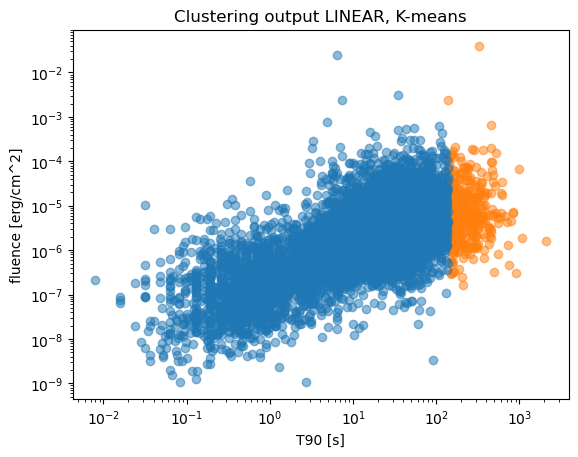

In [9]:
#K-means linear
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], color=colors[ii],alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("T90 [s]") 
plt.ylabel("fluence [erg/cm^2]") 
plt.title('Clustering output LINEAR, K-means');

Text(0.5, 1.0, 'Clustering output Log, K-means')

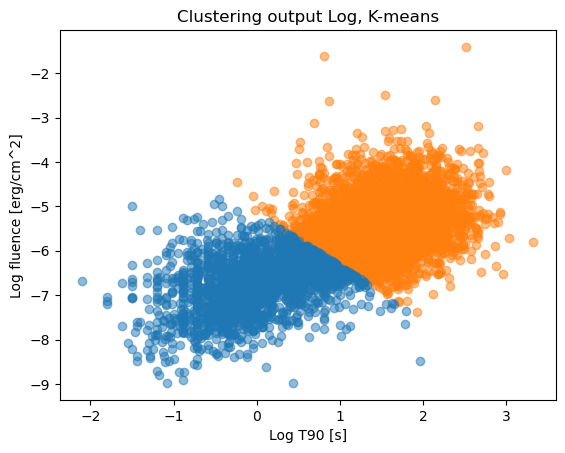

In [20]:
# K-means LOG

X = np.stack((np.log10(T90_[fluence_>0]), np.log10(fluence_[fluence_>0])), axis=1) 

from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.xlabel("Log T90 [s]") 
plt.ylabel("Log fluence [erg/cm^2]") 

plt.title('Clustering output Log, K-means')

In [27]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X_scaled, quantile=0.2, n_samples=500)
print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 0.905137623226427


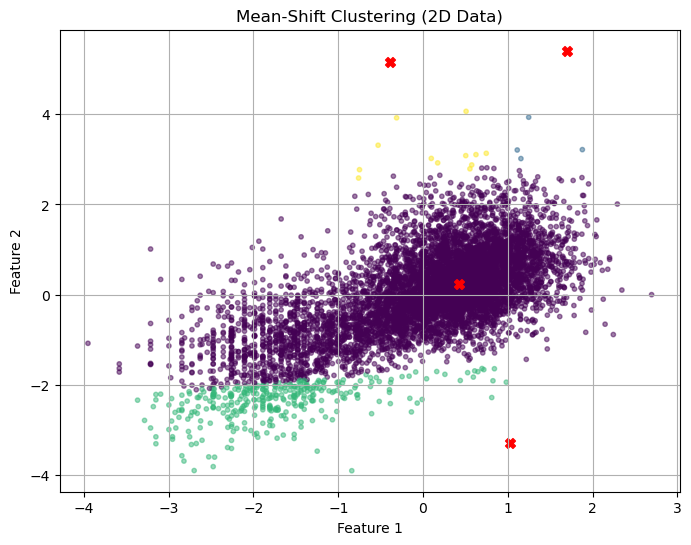

In [50]:
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn import preprocessing

# Scale the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Mean-Shift
bandwidth = 0.9
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X_scaled)

# Get cluster labels and centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, s=10, alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
            c='red', s=50, marker='X', label='Cluster Centers')
plt.title('Mean-Shift Clustering (2D Data)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()
